<a href="https://colab.research.google.com/github/k2-fsa/colab/blob/master/icefall/ctc_forced_alignment_fst_based_kaldi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This colab shows how to use [icefall](https://github.com/k2-fsa/icefall) for
fst-based forced alignment on CPU with [kaldi-decoder](https://github.com/k2-fsa/kaldi-decoder)

Please see also
https://k2-fsa.github.io/icefall/fst-based-forced-alignment/index.html

In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.3.0+cu121
2.3.0+cu121


In [2]:
%%shell
pip install -qq lhotse

# please refer to https://k2-fsa.github.io/k2/cpu.html
# to replace `1.24.4.dev20240425+cpu.torch2.3.0` with the latest version.
#
# For instance, if the colab updates its torch, you also need to replace torch2.3.0 below

pip install -qq k2==1.24.4.dev20240425+cpu.torch2.3.0 -f https://k2-fsa.github.io/k2/cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.2/782.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 63.1 MB/s eta 0:00:00


In [ ]:
%%shell
rm -rf icefall
git clone https://github.com/k2-fsa/icefall
cd icefall
pip install -q -r ./requirements.txt

## Download test wave

In [4]:
import torchaudio

# Download test wave
speech_file = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
print(speech_file)
waveform, sr = torchaudio.load(speech_file)
transcript = "i had that curiosity beside me at this moment".split()
print(waveform.shape, sr)

assert waveform.ndim == 2
assert waveform.shape[0] == 1
assert sr == 16000

100%|██████████| 106k/106k [00:00<00:00, 65.6MB/s]


/root/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav
torch.Size([1, 54400]) 16000


In [5]:
%%shell
ls -lh $HOME/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav

-rw-r--r-- 1 root root 107K Jun 12 08:02 /root/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav


In [6]:
from google.colab import files
files.download('/root/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import Audio, display


display(Audio(speech_file, autoplay=True))

In [7]:
bundle = torchaudio.pipelines.MMS_FA

model = bundle.get_model(with_star=False).to(device)

Downloading: "https://dl.fbaipublicfiles.com/mms/torchaudio/ctc_alignment_mling_uroman/model.pt" to /root/.cache/torch/hub/checkpoints/model.pt
100%|██████████| 1.18G/1.18G [00:07<00:00, 161MB/s]


In [8]:
with torch.inference_mode():
    emission, _ = model(waveform.to(device))
    print(emission.shape)

torch.Size([1, 169, 28])


In [9]:
token2id = bundle.get_dict(star=None)
id2token = {i:t for t, i in token2id.items()}
token2id["<eps>"] = 0
del token2id["-"]

In [10]:
# create word2id and id2word
words = list(set(transcript))
word2id = dict()
word2id['eps'] = 0
for i, w in enumerate(words):
  word2id[w] = i + 1

id2word = {i:w for w, i in word2id.items()}

In [11]:
import sys
sys.path.insert(0, '/content/icefall')
sys.path.insert(0, '/content/icefall/egs/librispeech/ASR/local')
from prepare_lang import add_disambig_symbols

lexicon = [(w, list(w)) for w in word2id if w != "eps"]
lexicon_disambig, max_disambig_id = add_disambig_symbols(lexicon)

with open('lexicon.txt', 'w', encoding='utf-8') as f:
  for w, tokens in lexicon:
    f.write(f"{w} {' '.join(tokens)}\n")

with open('lexicon_disambig.txt', 'w', encoding='utf-8') as f:
  for w, tokens in lexicon_disambig:
    f.write(f"{w} {' '.join(tokens)}\n")

with open('tokens.txt', 'w', encoding='utf-8') as f:
  for t, i in token2id.items():
    if t == '-':
      t = "<eps>"
    f.write(f"{t} {i}\n")

  for k in range(max_disambig_id + 2):
    f.write(f"#{k} {len(token2id) + k}\n")

with open('words.txt', 'w', encoding='utf-8') as f:
  for w, i in word2id.items():
    f.write(f"{w} {i}\n")
  f.write(f'#0 {len(word2id)}\n')

In [12]:
%%shell

head -n 50 lexicon.txt lexicon_disambig.txt tokens.txt words.txt

==> lexicon.txt <==
moment m o m e n t
beside b e s i d e
i i
this t h i s
curiosity c u r i o s i t y
had h a d
that t h a t
at a t
me m e

==> lexicon_disambig.txt <==
moment m o m e n t
beside b e s i d e
i i
this t h i s
curiosity c u r i o s i t y
had h a d
that t h a t
at a t
me m e

==> tokens.txt <==
a 1
i 2
e 3
n 4
o 5
u 6
t 7
s 8
r 9
m 10
k 11
l 12
d 13
g 14
h 15
y 16
b 17
p 18
w 19
c 20
v 21
j 22
z 23
f 24
' 25
q 26
x 27
<eps> 0
#0 28
#1 29

==> words.txt <==
eps 0
moment 1
beside 2
i 3
this 4
curiosity 5
had 6
that 7
at 8
me 9
#0 10


In [13]:
%%shell

export PYTHONPATH=/content/icefall:$PYTHONPATH

/content/icefall/egs/librispeech/ASR/local/prepare_lang_fst.py --lang-dir ./

2024-06-12 08:28:02.629928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 08:28:02.629998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 08:28:02.631744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 08:28:03.976167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-12 08:28:06,616 INFO [prepare_lang_fst.py:174] Building standard CTC topology
2024-06-12 08:28:06,632 INFO [prepare_lang_fst.py:183] Building L
2024-06-12 08:28:06,635 INFO [prepare_lang_fst.py:191] Building HL
2024-06-12 08:28:06,63

In [14]:
%%shell
ls -lh *.fst

-rw-r--r-- 1 root root  13K Jun 12 08:28 H.fst
-rw-r--r-- 1 root root 3.7K Jun 12 08:28 HL.fst


In [21]:
from kaldi_decoder import DecodableCtc, FasterDecoder, FasterDecoderOptions
import kaldifst

def force_align():
    HL = kaldifst.StdVectorFst.read("./HL.fst")
    decodable = DecodableCtc(emission[0].contiguous().cpu().numpy())
    decoder_opts = FasterDecoderOptions(max_active=3000)
    decoder = FasterDecoder(HL, decoder_opts)
    decoder.decode(decodable)
    if not decoder.reached_final():
        print(f"failed to decode xxx")
        return None
    ok, best_path = decoder.get_best_path()

    (
        ok,
        isymbols_out,
        osymbols_out,
        total_weight,
    ) = kaldifst.get_linear_symbol_sequence(best_path)
    if not ok:
        print(f"failed to get linear symbol sequence for xxx")
        return None

    # We need to use i-1 here since we have incremented tokens during
    # HL construction
    alignment = [i-1 for i in isymbols_out]
    return alignment

alignment = force_align()

for i, a in enumerate(alignment):
  print(i, id2token[a])

# The result should be identical to
# https://pytorch.org/audio/main/tutorials/ctc_forced_alignment_api_tutorial.html#frame-level-alignments

0 -
1 -
2 -
3 -
4 -
5 -
6 -
7 -
8 -
9 -
10 -
11 -
12 -
13 -
14 -
15 -
16 -
17 -
18 -
19 -
20 -
21 -
22 -
23 -
24 -
25 -
26 -
27 -
28 -
29 -
30 -
31 -
32 i
33 -
34 -
35 h
36 h
37 a
38 -
39 -
40 -
41 d
42 -
43 -
44 t
45 h
46 -
47 a
48 -
49 -
50 t
51 -
52 -
53 -
54 c
55 -
56 -
57 -
58 u
59 u
60 -
61 -
62 -
63 r
64 -
65 i
66 -
67 -
68 -
69 -
70 -
71 -
72 o
73 -
74 -
75 -
76 -
77 -
78 -
79 s
80 -
81 -
82 -
83 i
84 -
85 t
86 -
87 -
88 y
89 -
90 -
91 -
92 -
93 b
94 -
95 e
96 -
97 -
98 -
99 -
100 -
101 s
102 -
103 -
104 -
105 -
106 -
107 -
108 -
109 -
110 i
111 -
112 -
113 d
114 e
115 -
116 m
117 -
118 -
119 e
120 -
121 -
122 -
123 -
124 a
125 -
126 -
127 t
128 -
129 t
130 h
131 -
132 i
133 -
134 -
135 -
136 s
137 -
138 -
139 -
140 -
141 m
142 -
143 -
144 o
145 -
146 -
147 -
148 m
149 -
150 -
151 e
152 -
153 n
154 -
155 t
156 -
157 -
158 -
159 -
160 -
161 -
162 -
163 -
164 -
165 -
166 -
167 -
168 -


In [22]:
import sys
sys.path.insert(0, '/content/icefall')

from icefall.ctc.utils import merge_tokens
token_spans = merge_tokens(alignment)
for span in token_spans:
  print(id2token[span.token], span.start, span.end)

i 32 33
h 35 37
a 37 38
d 41 42
t 44 45
h 45 46
a 47 48
t 50 51
c 54 55
u 58 60
r 63 64
i 65 66
o 72 73
s 79 80
i 83 84
t 85 86
y 88 89
b 93 94
e 95 96
s 101 102
i 110 111
d 113 114
e 114 115
m 116 117
e 119 120
a 124 125
t 127 128
t 129 130
h 130 131
i 132 133
s 136 137
m 141 142
o 144 145
m 148 149
e 151 152
n 153 154
t 155 156


The following code
is copied and modified from
https://pytorch.org/audio/main/tutorials/ctc_forced_alignment_api_tutorial.html

In [23]:
def unflatten(list_, lengths):
    assert len(list_) == sum(lengths)
    i = 0
    ret = []
    for l in lengths:
        ret.append(list_[i : i + l])
        i += l
    return ret


word_spans = unflatten(token_spans, [len(word) for word in transcript])
print(word_spans)

[[TokenSpan(token=2, start=32, end=33)], [TokenSpan(token=15, start=35, end=37), TokenSpan(token=1, start=37, end=38), TokenSpan(token=13, start=41, end=42)], [TokenSpan(token=7, start=44, end=45), TokenSpan(token=15, start=45, end=46), TokenSpan(token=1, start=47, end=48), TokenSpan(token=7, start=50, end=51)], [TokenSpan(token=20, start=54, end=55), TokenSpan(token=6, start=58, end=60), TokenSpan(token=9, start=63, end=64), TokenSpan(token=2, start=65, end=66), TokenSpan(token=5, start=72, end=73), TokenSpan(token=8, start=79, end=80), TokenSpan(token=2, start=83, end=84), TokenSpan(token=7, start=85, end=86), TokenSpan(token=16, start=88, end=89)], [TokenSpan(token=17, start=93, end=94), TokenSpan(token=3, start=95, end=96), TokenSpan(token=8, start=101, end=102), TokenSpan(token=2, start=110, end=111), TokenSpan(token=13, start=113, end=114), TokenSpan(token=3, start=114, end=115)], [TokenSpan(token=10, start=116, end=117), TokenSpan(token=3, start=119, end=120)], [TokenSpan(token=

In [24]:
import IPython
print(transcript)
IPython.display.Audio(speech_file)

['i', 'had', 'that', 'curiosity', 'beside', 'me', 'at', 'this', 'moment']


In [25]:
def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)
num_frames = emission.size(1)

In [26]:
preview_word(waveform, word_spans[0], num_frames, transcript[0])

i 0.644 - 0.664 sec


In [32]:
preview_word(waveform, word_spans[1], num_frames, transcript[1])

had 0.704 - 0.845 sec


In [33]:
preview_word(waveform, word_spans[2], num_frames, transcript[2])

that 0.885 - 1.026 sec


In [34]:
preview_word(waveform, word_spans[3], num_frames, transcript[3])

curiosity 1.086 - 1.790 sec


In [35]:
preview_word(waveform, word_spans[4], num_frames, transcript[4])

beside 1.871 - 2.314 sec


In [36]:
preview_word(waveform, word_spans[5], num_frames, transcript[5])

me 2.334 - 2.414 sec


In [37]:
preview_word(waveform, word_spans[6], num_frames, transcript[6])

at 2.495 - 2.575 sec


In [38]:
preview_word(waveform, word_spans[7], num_frames, transcript[7])

this 2.595 - 2.756 sec


In [39]:
preview_word(waveform, word_spans[8], num_frames, transcript[8])

moment 2.837 - 3.138 sec


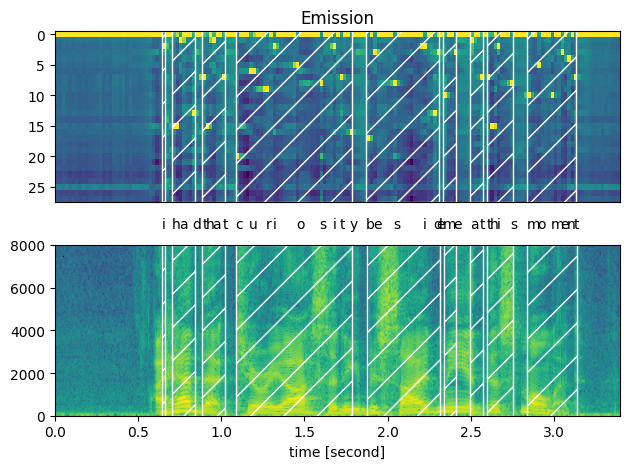

In [40]:
import matplotlib.pyplot as plt

def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start + 0.1, t_spans[-1].end - 0.1
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    axes[1].set_xlim([0, None])
    fig.tight_layout()
plot_alignments(waveform, word_spans, emission, transcript)
